In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, KFold
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.io
import scanpy as sc
from sklearn.decomposition import PCA

# suppress non-convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)


# groups of genes of interest
gene_groups = {
    'immune_genes': ['CD8A', 'PDCD1', 'CTLA4', 'FOXP3', 'GZMB', 'CD274', 'TGFBR2', 'IL6', 'TNF'], 
    'metabolic_genes': ['SLC2A1', 'LDHA', 'IDH1', 'IDH2', 'ACLY', 'HK2', 'GPI'],  
    'signaling_genes': ['KRAS', 'PIK3CA', 'EGFR', 'TP53', 'MYC', 'AKT1', 'MAPK1', 'BRAF']  
}


label_mapping = {'core': 0, 'edge': 1} # define the label mapping

print("Cell 1 complete")


Cell 1 complete


In [3]:
def load_data():
    file_path_ct = "mergedata/counts.mtx"
    file_path_normct = "mergedata/normcounts.mtx"
    file_path_md = "mergedata/metadata.csv"
    file_path_genes = "mergedata/genenames.csv"
    file_path_barcodes = "mergedata/barcodes.csv"

    ct = scipy.io.mmread(file_path_ct).T
    ct = sp.csr_matrix(ct)
    barcodes = pd.read_csv(file_path_barcodes).values.flatten()
    genes = pd.read_csv(file_path_genes).values.flatten()
    md = pd.read_csv(file_path_md, index_col=0)

    adata = sc.AnnData(ct)
    adata.obs_names = barcodes
    adata.var_names = genes
    adata.obs = md

    ctn = scipy.io.mmread(file_path_normct).T
    ctn = sp.csr_matrix(ctn)
    adata.X_norm = ctn

    gene_expression_data = pd.DataFrame(adata.X_norm.toarray(), columns=genes, index=barcodes)

    # The dataset includes other possible labels, but we are only interested in 'core' and 'edge' 
    valid_labels = ['core', 'edge']
    valid_barcodes = adata.obs[adata.obs['cluster_annotations'].isin(valid_labels)].index

    # apply valid_barcodes filter to _labels and _expression
    filtered_gene_expression = gene_expression_data.loc[valid_barcodes]
    filtered_labels = adata.obs.loc[valid_barcodes, 'cluster_annotations']

    # sort the labels and expression together by barcode (index)
    filtered_gene_expression = filtered_gene_expression.loc[filtered_labels.index]

    return filtered_gene_expression, filtered_labels


filtered_gene_expression, filtered_labels = load_data()

gene_expression_data, cluster_labels = filtered_gene_expression, filtered_labels

print("cell 3 done")

cell 3 done


In [4]:
import numpy as np
import pandas as pd

def select_top_genes(gene_expression_data, cluster_labels, epsilon=1e-10):
    
    print(f"\n------- Top log2FC Genes Feature Selection Method (Biologically relevant, but learns from labels) -------")
    print('*' * 100)
    print(f"Input data shape: {gene_expression_data.shape}")
    print(f"Number of core samples: {sum(cluster_labels == 'core')}")
    print(f"Number of edge samples: {sum(cluster_labels == 'edge')}")
    print()

    assert gene_expression_data.index.equals(cluster_labels.index), "Indices of gene_expression_data and cluster_labels do not match"

    coremask = cluster_labels == "core"
    edgemask = cluster_labels == "edge"

    meancore = gene_expression_data.loc[coremask].mean()
    non0core = (gene_expression_data.loc[coremask] > 0).mean()
    meanedge = gene_expression_data.loc[edgemask].mean()
    non0edge = (gene_expression_data.loc[edgemask] > 0).mean()

    print(f"Mean expression in core: {meancore.mean():.4f}")
    print(f"Mean expression in edge: {meanedge.mean():.4f}")
    print(f"Mean non-zero percentage in core: {non0core.mean():.4f}")
    print(f"Mean non-zero percentage in edge: {non0edge.mean():.4f}")
    print()

    # calculate log2 fold change with pseudocount
    log2FC = np.log2((meancore + epsilon) / (meanedge + epsilon))

    results = pd.DataFrame({
        'log2FC': log2FC,
        'pct_core': non0core,
        'pct_edge': non0edge,
        'dpct': non0core - non0edge
    })

    print(f"Number of genes with valid log2FC: {results['log2FC'].notna().sum()}")

    # sort by absolute log2FC to capture both up and down regulated genes
    results['abs_log2FC'] = np.abs(results['log2FC'])
    results.sort_values(by="abs_log2FC", ascending=False, inplace=True)

    # select top 20 genes (10 most positive and 10 most negative log2FC)
    selected_genes = results.nlargest(20, 'abs_log2FC').index

    print(f"Number of selected genes: {len(selected_genes)}")
    print()
    print("Top 5 up-regulated genes:")
    print(results.nlargest(5, 'log2FC'))
    print()
    print("\nTop 5 down-regulated genes:")
    print(results.nsmallest(5, 'log2FC'))

    # filter gene expression data and add cluster labels
    filtered_gene_expression_data = gene_expression_data.loc[:, selected_genes].copy()
    filtered_gene_expression_data['label'] = cluster_labels

    df = filtered_gene_expression_data
    df = df.drop(df.columns[-1], axis=1)
    filtered_gene_expression_data = df
    print()  
    print(f"Filtered data shape: {filtered_gene_expression_data.shape}")
    print('*' * 100)
    return filtered_gene_expression_data, selected_genes


In [5]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold

# suppress non-convergence warnings, quite noisy
warnings.filterwarnings("ignore")

def select_k_best(gene_expression_data, cluster_labels, task='evaluate', k_best=20):
    results = {}
    k_best_test = [50, 100, 200]
    if task != 'evaluate':
        print(f"\n---Select_K_Best (K={k_best}) Feature Selection Method (Biologically relevant, but learns from labels)---")
        print('*' * 100)
        print(f"Input data shape: {gene_expression_data.shape}")
        print()
        feature_filter = SelectKBest(score_func=f_classif, k=k_best)
        filtered_data = feature_filter.fit_transform(gene_expression_data, cluster_labels)

        selected_genes = gene_expression_data.columns[feature_filter.get_support()].tolist() #returns boolean array indicating if features were kept
        filtered_df = pd.DataFrame(filtered_data, columns=selected_genes) # used to ID genes that were select_k_bested
        
        scores = feature_filter.scores_[feature_filter.get_support()] #similar for scores

        gene_scores = pd.DataFrame({'Gene': selected_genes, 'Score': scores})
        gene_scores = gene_scores.sort_values('Score', ascending=False) 
        
        top_10_genes = gene_scores.head(10)
        
        print(f"Top ten genes from select_k_best, where K={k_best}:")
        print(top_10_genes)
        print()
        print(f"Filtered data shape: {filtered_data.shape}")
        print('*' * 100)
        return filtered_data
    else:
        for k in k_best_test:
            feature_filter = SelectKBest(score_func=f_classif, k=k)
            X_train = feature_filter.fit_transform(gene_expression_data, cluster_labels)
            mean_cv_accuracy = train_evaluate_model(X_train, cluster_labels)
            results[f'k_best_{k}'] = mean_cv_accuracy
            print(f"Completed k_best={k} with accuracy={mean_cv_accuracy:.4f}")
        print("Completed select_k_best function.")
        return results

def variance_threshold(gene_expression_data, cluster_labels, task='evaluate', threshold=1):
    results = {}
    threshold_tests = [0.2, 0.5]
    if task != 'evaluate':
        print()
        print(f"\n--------- Variance Threshold Feature Selection Method (Course Appropriate) --------")
        print('*' * 100)
        print(f"Input data shape: {gene_expression_data.shape}")

        feature_filter = VarianceThreshold(threshold=threshold)
        feature_filter.fit(gene_expression_data)
        
        keep_features = feature_filter.get_support()
        
        filtered_data = gene_expression_data.loc[:, keep_features]
        print(f'Number of genes meeting variance threshold: {filtered_data.shape}')        
        print()
        gene_variances = filtered_data.var().sort_values(ascending=False)
        top_10_genes = gene_variances.head(10)
        
        print("Top ten genes with greatest variance:")
        print(top_10_genes)
        print()
        print(f"Filtered data shape: {filtered_data.shape}")
        print('*' * 100)
        
        return filtered_data
    else:
        for threshold in threshold_tests:
            feature_filter = VarianceThreshold(threshold=threshold)
            X_train = feature_filter.fit_transform(gene_expression_data)
            mean_cv_accuracy = train_evaluate_model(X_train, cluster_labels)
            results[f'threshold test_{threshold}'] = mean_cv_accuracy
            print(f"Completed threshold test={threshold} with accuracy={mean_cv_accuracy:.4f}")
        print("Completed variance_threshold function.")
        return results

def gene_groups_test(gene_expression_data, cluster_labels, gene_groups, task='evaluate'):
    results = {} 
    if task != 'evaluate':
        print()
        print(f"\n-------- Predefined Gene Groups Feature Selection Method (Course Appropriate) ---------")
        print('*' * 100)
        print(f"Input data shape: {gene_expression_data.shape}")
        names, first_group = next(iter(gene_groups.items()))  # get the first group of genes, defined at the top
        filtered_data = gene_expression_data[first_group]  # filter gene_expression_data to include only genes in the first group
        print(f"Complete list of genes used as feature selectors in this method:")
        print()
        print(names)
        [print(genes) for genes in first_group]
        print()
        print(f"Filtered data shape: {filtered_data.shape}")
        print('*' * 100)
        return filtered_data
    else:
        for group, genes in gene_groups.items():
            X_train = gene_expression_data[genes]
            mean_cv_accuracy = train_evaluate_model(X_train, cluster_labels)
            results[f'gene groups_{group}'] = mean_cv_accuracy
            print(f"Completed gene group={group} with accuracy={mean_cv_accuracy:.4f}")
        print("Completed gene_groups function.")
        return results

    
## Below: Create the datasets for each feature selection method

top_genes_data, selected_genes = select_top_genes(gene_expression_data, cluster_labels)

df = gene_expression_data
df = df.drop(df.columns[-1], axis=1)
gene_expression_data = df
print()
print()

select_k_data = select_k_best(gene_expression_data, cluster_labels, task='feature selection')

print(f'*** THE DF IS CLEAN of LABELS, creating feature selected datasets now (variance, gene_groups) ***')
print()

variance_data = variance_threshold(gene_expression_data, cluster_labels, task= 'feature selection') #clusters passed as eval method
gene_groups_data = gene_groups_test(gene_expression_data, cluster_labels, gene_groups, task="feature selection") #clusters pass as eval method



------- Top log2FC Genes Feature Selection Method (Biologically relevant, but learns from labels) -------
****************************************************************************************************
Input data shape: (8931, 20526)
Number of core samples: 1929
Number of edge samples: 7002

Mean expression in core: 0.0919
Mean expression in edge: 0.0967
Mean non-zero percentage in core: 0.1024
Mean non-zero percentage in edge: 0.1057

Number of genes with valid log2FC: 20526
Number of selected genes: 20

Top 5 up-regulated genes:
               log2FC  pct_core  pct_edge      dpct  abs_log2FC
IL36A       26.643287  0.014515       0.0  0.014515   26.643287
AC011139.1  25.584232  0.007258       0.0  0.007258   25.584232
AC139769.2  25.496052  0.006221       0.0  0.006221   25.496052
LINC02310   25.098805  0.005184       0.0  0.005184   25.098805
AC021491.1  24.361840  0.003110       0.0  0.003110   24.361840


Top 5 down-regulated genes:
               log2FC  pct_core  pct_edge  

In [6]:
from sklearn.preprocessing import PolynomialFeatures

def polynomial_features(arr, degree=2, interaction_only=False, include_bias=False):
    poly = PolynomialFeatures(degree=degree, interaction_only=interaction_only, include_bias=include_bias)
    poly_features = poly.fit_transform(arr)

    return poly_features


In [7]:
print('Initializing')
print()
variance_poly_data = polynomial_features(variance_data, degree=2)

gene_groups_poly_data = polynomial_features(gene_groups_data, degree=3)

print(f"Original variance_data shape: {variance_data.shape}")
print(f"Polynomial variance_data shape(deg=2): {variance_poly_data.shape}")
print()
print(f"Original gene_groups_data shape: {gene_groups_data.shape}")
print(f"Polynomial gene_groups_data shape(deg=3): {gene_groups_poly_data.shape}")

Initializing

Original variance_data shape: (8931, 10)
Polynomial variance_data shape(deg=2): (8931, 65)

Original gene_groups_data shape: (8931, 9)
Polynomial gene_groups_data shape(deg=3): (8931, 219)


In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

def train_evaluate_models(X_train, y_train, n_splits=10):
    models = {
        'MLP': MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=1000, batch_size=32, random_state=1),
        'SVM': SVC(kernel='linear', C=1, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    }
   
    for name, model in models.items():
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
        model.fit(X_train, y_train)
        print(f"{name} Mean Cross-Validation Accuracy: {scores.mean():.4f}")
   
    return models

def perform_train_test_split(X, y):
    return train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from joblib import Parallel, delayed  # Code altered to make parallel processing possible in process_feature_selection below

def perform_train_test_split(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

def train_evaluate_models(X_train, y_train):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import SVC
    from sklearn.neural_network import MLPClassifier
    models = {
        'MLP': MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=1000, batch_size=32, random_state=1),
        'SVM': SVC(kernel='linear', C=1, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    }
    for name, model in models.items():
        model.fit(X_train, y_train)
    return models

def evaluate_model(model, X_test, y_test):
    from sklearn.metrics import f1_score, recall_score, roc_auc_score, precision_score
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    accuracy = model.score(X_test, y_test)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    precision = precision_score(y_test, y_pred, zero_division=0)
    
    auroc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    metrics = {
        'accuracy': accuracy,
        'f1': f1,
        'recall': recall,
        'precision': precision,
        'auroc': auroc
    }
    return metrics

all_results = []
cv_scores = {}

feature_selections = [variance_poly_data, gene_groups_poly_data, variance_data, gene_groups_data, top_genes_data, select_k_data]
feature_names = ["Variance Threshold Polynomial Features", "Gene Groups Polynomial Features", "Variance Threshold", "Gene Groups", "Top Genes", "Select K"]

def process_feature_selection(i, data, name, cluster_labels):  # converting this code into parallel processing was aided by Antropic, an LLM
    results = []                                               # it was done to aid in quick processing on pace and is almost entirely based on my original code
   
    X = data
    label_mapping = {'edge': 0, 'core': 1}
    y = np.array([label_mapping[label] for label in cluster_labels])
    X_train, X_test, y_train, y_test = perform_train_test_split(X, y)

    models = train_evaluate_models(X_train, y_train)

    for model_name, model in models.items():
        metrics = evaluate_model(model, X_test, y_test)
        cv_score = cross_val_score(model, X_train, y_train, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42), scoring='accuracy')

        accuracy = metrics['accuracy']
        f1 = metrics['f1']
        recall = metrics['recall']
        precision = metrics['precision']
        auroc = metrics['auroc']
        
        results.append({
            'Feature Selection': name,
            'Model': model_name,
            'Test Accuracy': metrics['accuracy'],
            'Test F1 Score': metrics['f1'],
            'Test Recall': metrics['recall'],
            'Test Precision': metrics['precision'],
            'Test AUROC': metrics['auroc'],
            'CV Mean Accuracy': cv_score.mean(),
            'CV Std Accuracy': cv_score.std()
        })

        if model_name not in cv_scores:
            cv_scores[model_name] = {}
        cv_scores[model_name][name] = cv_score

    
    print()

    return results

results = Parallel(n_jobs=-1)(
    delayed(process_feature_selection)(i, data, name, cluster_labels)
    for i, (data, name) in enumerate(zip(feature_selections, feature_names))
)

for result in results:
    all_results.extend(result)



In [43]:
df_results = pd.DataFrame(all_results)


def print_results(df_results):
    df = df_results
    methods = df['Feature Selection'].unique()
    for method in methods:
        mask = df[df['Feature Selection'] == method] # method mask
        print()
        print("*" * 100)
        print(f'                     Results for {method}')
        print()
        print(mask.iloc[:, 1:])
        print()
        print()
        
print_results(df_results)



****************************************************************************************************
                     Results for Variance Threshold Polynomial Features

           Model  Test Accuracy  Test F1 Score  Test Recall  Test Precision  \
0            MLP       0.961388       0.911425     0.919689        0.903308   
1            SVM       0.954113       0.890667     0.865285        0.917582   
2  Random Forest       0.959149       0.902537     0.875648        0.931129   

   Test AUROC  CV Mean Accuracy  CV Std Accuracy  
0    0.990688          0.956467         0.007176  
1         NaN          0.955347         0.006306  
2    0.991666          0.960246         0.005950  



****************************************************************************************************
                     Results for Gene Groups Polynomial Features

           Model  Test Accuracy  Test F1 Score  Test Recall  Test Precision  \
3            MLP       0.780078        0.03912     0.02

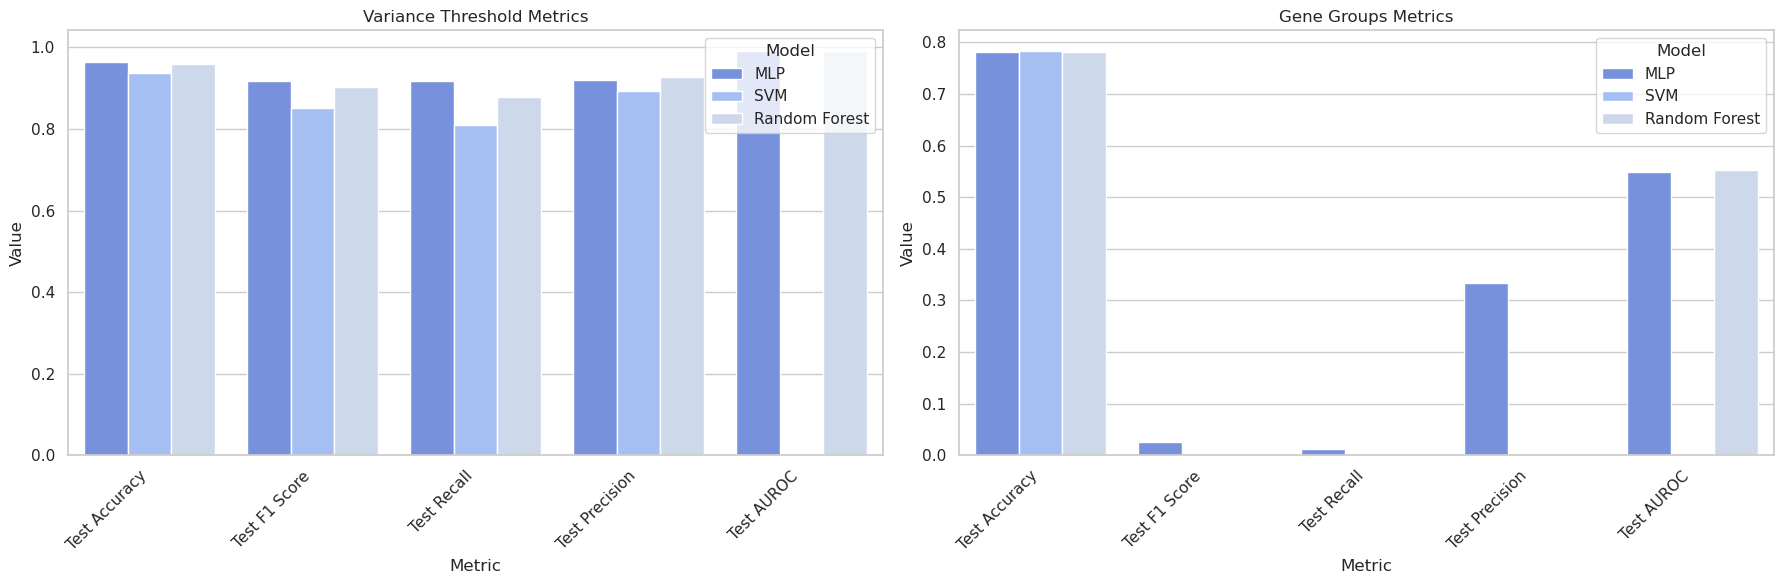

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("coolwarm")

var_mask = df[df['Feature Selection'] == "Variance Threshold"]
gene_mask = df[df['Feature Selection'] == "Gene Groups"]

df1 = pd.DataFrame(var_mask)
df2 = pd.DataFrame(gene_mask)

def plot_metrics(df, title, ax):
    metrics = ['Test Accuracy', 'Test F1 Score', 'Test Recall', 'Test Precision', 'Test AUROC']
    df_melted = df.melt(id_vars=['Model'], value_vars=metrics, 
                        var_name='Metric', value_name='Value')
    sns.barplot(data=df_melted, x='Metric', y='Value', hue='Model', ax=ax)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


fig, axs = plt.subplots(1, 2, figsize=(18, 6))

plot_metrics(df1, 'Variance Threshold Metrics', axs[0])
plot_metrics(df2, 'Gene Groups Metrics', axs[1])


plt.tight_layout()
plt.show()
